# 1.23e: Flannel 6 Identity Check

**Goal:** Verify that Flannel 6 runs are identical (or measure how close they are).

Unlike 1.23d (which measured divergence from different initializations), this notebook tests whether training from the **same initialization** produces identical trajectories.

**Key questions:**
- Are the trajectories **exactly** identical (bit-for-bit)?
- Or do they differ by numerical precision limits (ε ≈ 1e-6 to 1e-15)?
- If they diverge, when does it start and how fast does it grow?

**Data:** Flannel 6 (10 runs from same initialization, varying training seed)

## Parameters

In [17]:
from pathlib import Path

# Paths
TENSOR_DIR = Path('../tensors/Flannel')
DATA_PATH = TENSOR_DIR / '1.20g_flannel_6b.safetensors'
MASK_PATH = TENSOR_DIR / 'live_dead_tokens.safetensors'

# Analysis parameters
RANDOM_SEED = 42

# Visualization
DPI = 200

## Imports

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from itertools import combinations
from tqdm.auto import tqdm

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print("Imports complete")

Imports complete


## Load Data

In [ ]:
# Load Flannel 6 or 6B data
print(f"Loading: {DATA_PATH}")
data = load_file(DATA_PATH)

# Full embedding matrix: (10 runs, 1001 timesteps, 10000 tokens, 64 dims)
W_full = data['W']
print(f"  Full W shape: {tuple(W_full.shape)}")

# Initial W (shared starting point)
W_initial = data['W_initial']
print(f"  W_initial shape: {tuple(W_initial.shape)}")

# Metadata - handle both formats
init_seed = data['init_seed'].item()
n_runs = data['n_runs'].item()

# Flannel 6 uses 'base_train_seed', Flannel 6B uses 'train_seed'
if 'base_train_seed' in data:
    base_train_seed = data['base_train_seed'].item()
    train_seed_end = base_train_seed + n_runs - 1
    seed_description = f"{base_train_seed}–{train_seed_end} (varying)"
elif 'train_seed' in data:
    train_seed = data['train_seed'].item()
    base_train_seed = train_seed  # For compatibility with summary cell
    seed_description = f"{train_seed} (fixed)"
else:
    base_train_seed = None
    seed_description = "unknown"

print(f"\n  Initialization seed: {init_seed}")
print(f"  Training seeds: {seed_description}")

# Load token mask
print(f"\nLoading: {MASK_PATH}")
mask_data = load_file(MASK_PATH)
dead_mask = mask_data['dead_mask'].bool()
n_dead = dead_mask.sum().item()
n_live = (~dead_mask).sum().item()
print(f"  Live tokens: {n_live:,}")
print(f"  Dead tokens: {n_dead:,}")

In [ ]:
# Extract dead tokens only
# Shape: (10 runs, 1001 timesteps, 3699 dead tokens, 64 dims)
W_dead = W_full[:, :, dead_mask, :].float()

n_runs, n_steps, n_tokens, n_dims = W_dead.shape
print(f"Dead token embeddings: {n_runs} runs, {n_steps} timesteps, {n_tokens} tokens, {n_dims} dimensions")
print(f"Memory: {W_dead.element_size() * W_dead.nelement() / 1024**3:.2f} GB")

Dead token embeddings: 10 runs, 1001 timesteps, 3699 tokens, 64 dimensions
Memory: 8.83 GB


## Initial State Verification

First, verify that all runs actually start from the same W.

In [ ]:
print("Verifying initial state identity...\n")

# Check that all runs have identical W at t=0
max_diff_t0 = 0.0
mean_diff_t0 = 0.0
n_pairs = 0

for i in range(n_runs):
    for j in range(i+1, n_runs):
        diff = (W_dead[i, 0] - W_dead[j, 0]).abs()
        max_diff_t0 = max(max_diff_t0, diff.max().item())
        mean_diff_t0 += diff.mean().item()
        n_pairs += 1

mean_diff_t0 /= n_pairs

print(f"t=0 (initialization):")
print(f"  Pairwise comparisons: {n_pairs}")
print(f"  Max absolute difference:  {max_diff_t0:.15e}")
print(f"  Mean absolute difference: {mean_diff_t0:.15e}")
print()

if max_diff_t0 == 0.0:
    print("  ✓ EXACTLY IDENTICAL (bit-for-bit)")
elif max_diff_t0 < 1e-10:
    print("  ✓ Effectively identical (within floating-point precision)")
else:
    print(f"  ⚠️  WARNING: Non-trivial differences at initialization!")

Verifying initial state identity...

t=0 (initialization):
  Pairwise comparisons: 45
  Max absolute difference:  0.000000000000000e+00
  Mean absolute difference: 0.000000000000000e+00

  ✓ EXACTLY IDENTICAL (bit-for-bit)


## Pairwise Differences Over Time

Compute Frobenius norm between every pair of runs at each timestep.

In [ ]:
# Compute pairwise Frobenius norms
n_pairs = n_runs * (n_runs - 1) // 2
run_pairs = list(combinations(range(n_runs), 2))

print(f"Computing Frobenius norms for {n_pairs} run pairs across {n_steps} timesteps...\n")

# Store: (n_steps, n_pairs)
pairwise_frob = torch.zeros(n_steps, n_pairs)

for t in tqdm(range(n_steps), desc="Timesteps"):
    for pair_idx, (i, j) in enumerate(run_pairs):
        diff = W_dead[i, t] - W_dead[j, t]
        pairwise_frob[t, pair_idx] = torch.norm(diff, p='fro')

print(f"\n✓ Computed {n_steps * n_pairs:,} pairwise distances")

Computing Frobenius norms for 45 run pairs across 1001 timesteps...



Timesteps:   0%|          | 0/1001 [00:00<?, ?it/s]


✓ Computed 45,045 pairwise distances


In [ ]:
# Summary statistics
frob_mean = pairwise_frob.mean(dim=1)
frob_median = pairwise_frob.median(dim=1)[0]
frob_std = pairwise_frob.std(dim=1)
frob_min = pairwise_frob.min(dim=1)[0]
frob_max = pairwise_frob.max(dim=1)[0]

print(f"\nPairwise Frobenius norms:")
print(f"\nt=0:")
print(f"  Mean:   {frob_mean[0]:.15e}")
print(f"  Median: {frob_median[0]:.15e}")
print(f"  Max:    {frob_max[0]:.15e}")
print(f"\nt=1000:")
print(f"  Mean:   {frob_mean[-1]:.15e}")
print(f"  Median: {frob_median[-1]:.15e}")
print(f"  Max:    {frob_max[-1]:.15e}")


Pairwise Frobenius norms:

t=0:
  Mean:   0.000000000000000e+00
  Median: 0.000000000000000e+00
  Max:    0.000000000000000e+00

t=1000:
  Mean:   3.143043708801270e+01
  Median: 3.140563201904297e+01
  Max:    3.857075500488281e+01


## Exact Identity Check

Check if any pairs are **exactly** identical (diff = 0.0) versus approximately identical.

In [ ]:
# Count exactly zero differences
exactly_zero = (pairwise_frob == 0.0).sum(dim=1)
nearly_zero = (pairwise_frob < 1e-10).sum(dim=1)
small = (pairwise_frob < 1e-6).sum(dim=1)

print(f"Exact identity analysis (out of {n_pairs} pairs):")
print(f"\nt=0:")
print(f"  Exactly zero (0.0):        {exactly_zero[0].item()}/{n_pairs}")
print(f"  Nearly zero (< 1e-10):     {nearly_zero[0].item()}/{n_pairs}")
print(f"  Small (< 1e-6):            {small[0].item()}/{n_pairs}")
print(f"\nt=1000:")
print(f"  Exactly zero (0.0):        {exactly_zero[-1].item()}/{n_pairs}")
print(f"  Nearly zero (< 1e-10):     {nearly_zero[-1].item()}/{n_pairs}")
print(f"  Small (< 1e-6):            {small[-1].item()}/{n_pairs}")

Exact identity analysis (out of 45 pairs):

t=0:
  Exactly zero (0.0):        45/45
  Nearly zero (< 1e-10):     45/45
  Small (< 1e-6):            45/45

t=1000:
  Exactly zero (0.0):        0/45
  Nearly zero (< 1e-10):     0/45
  Small (< 1e-6):            0/45


## Visualization

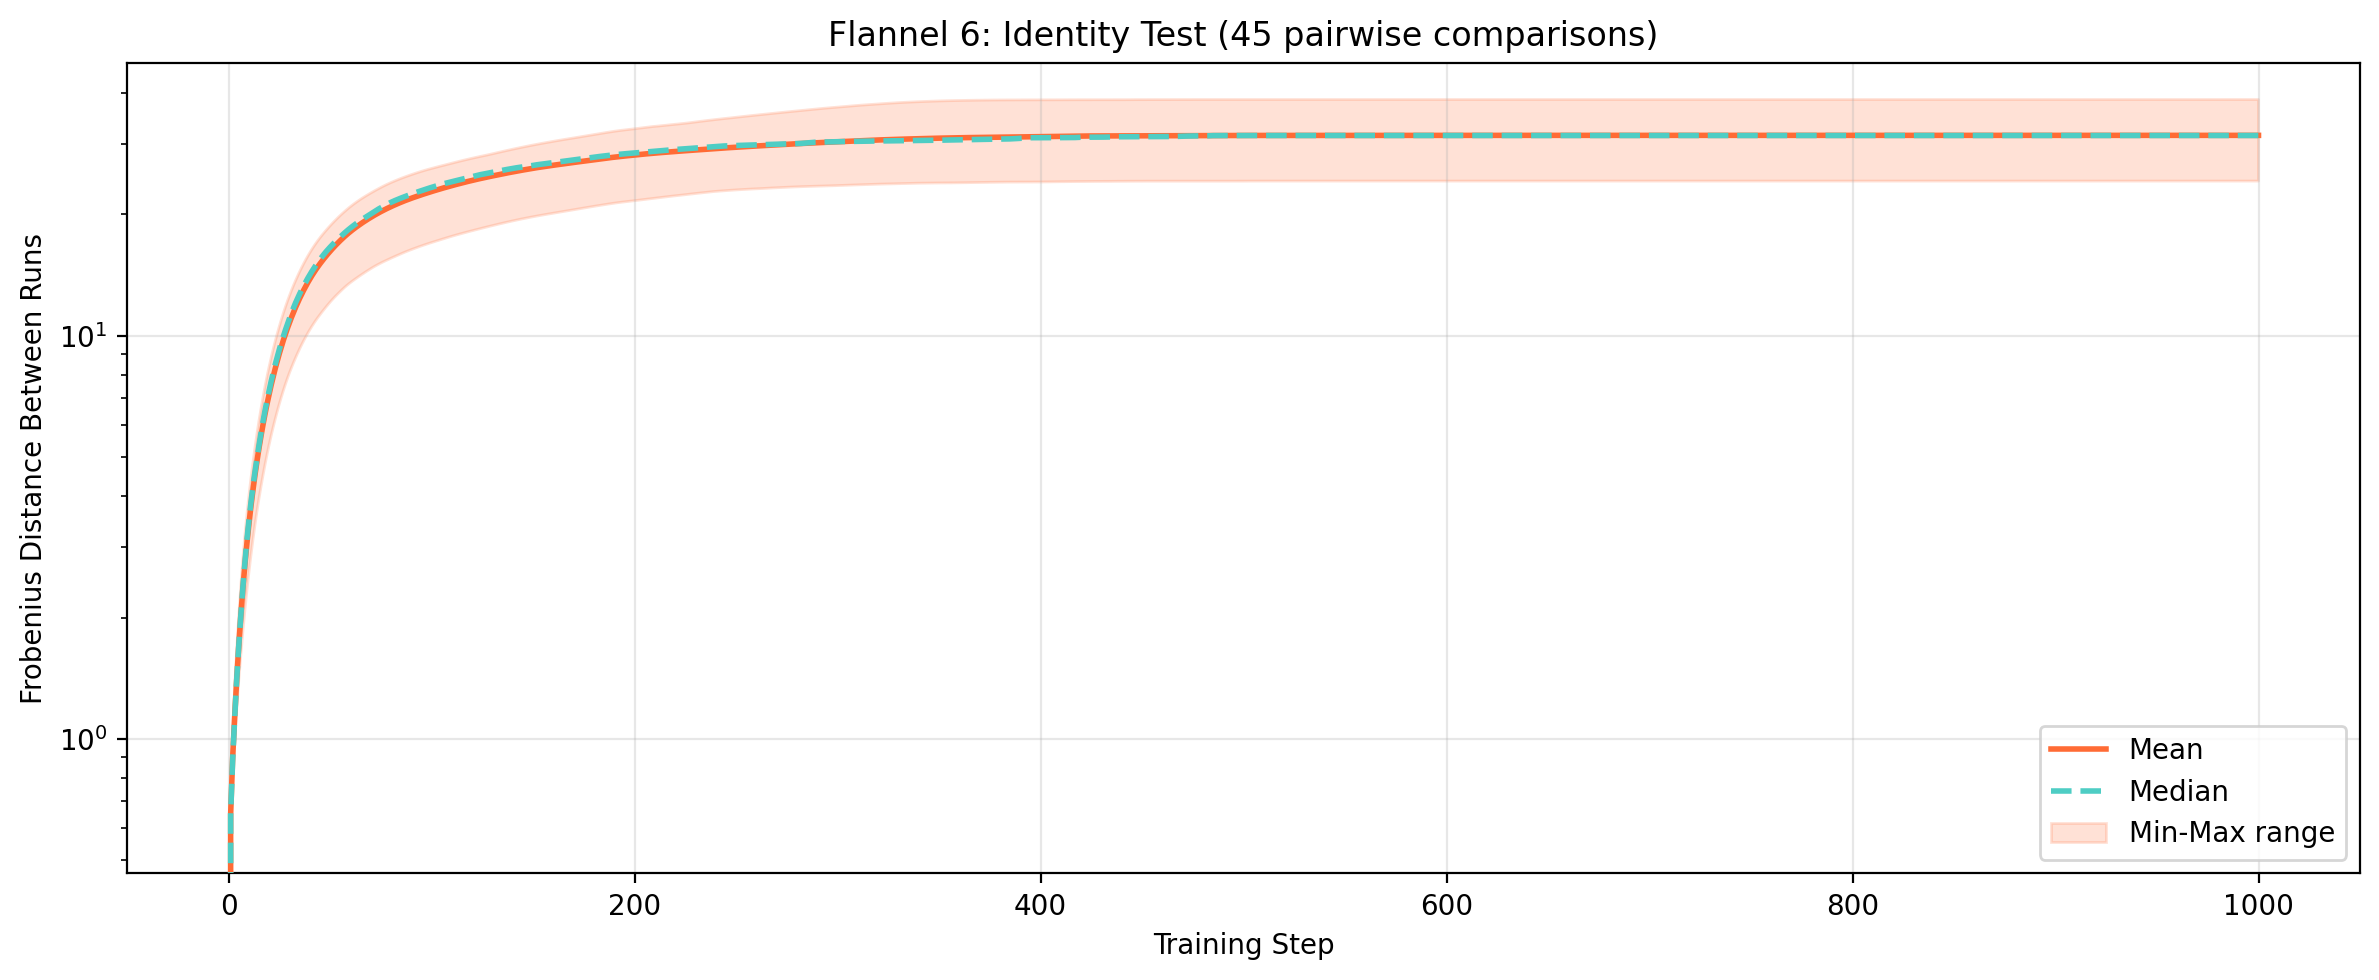

In [ ]:
# Plot pairwise differences over time
fig, ax = plt.subplots(figsize=(12, 5), dpi=DPI)

ax.plot(frob_mean.numpy(), linewidth=2, color='#FF6B35', label='Mean', zorder=3)
ax.plot(frob_median.numpy(), linewidth=2, color='#4ECDC4', label='Median', zorder=3, linestyle='--')
ax.fill_between(range(n_steps), 
                 frob_min.numpy(), 
                 frob_max.numpy(), 
                 alpha=0.2, color='#FF6B35', label='Min-Max range')

ax.set_xlabel('Training Step')
ax.set_ylabel('Frobenius Distance Between Runs')
ax.set_title(f'Flannel 6: Identity Test ({n_pairs} pairwise comparisons)')
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_yscale('log')  # Log scale to see small differences

plt.tight_layout()
plt.show()

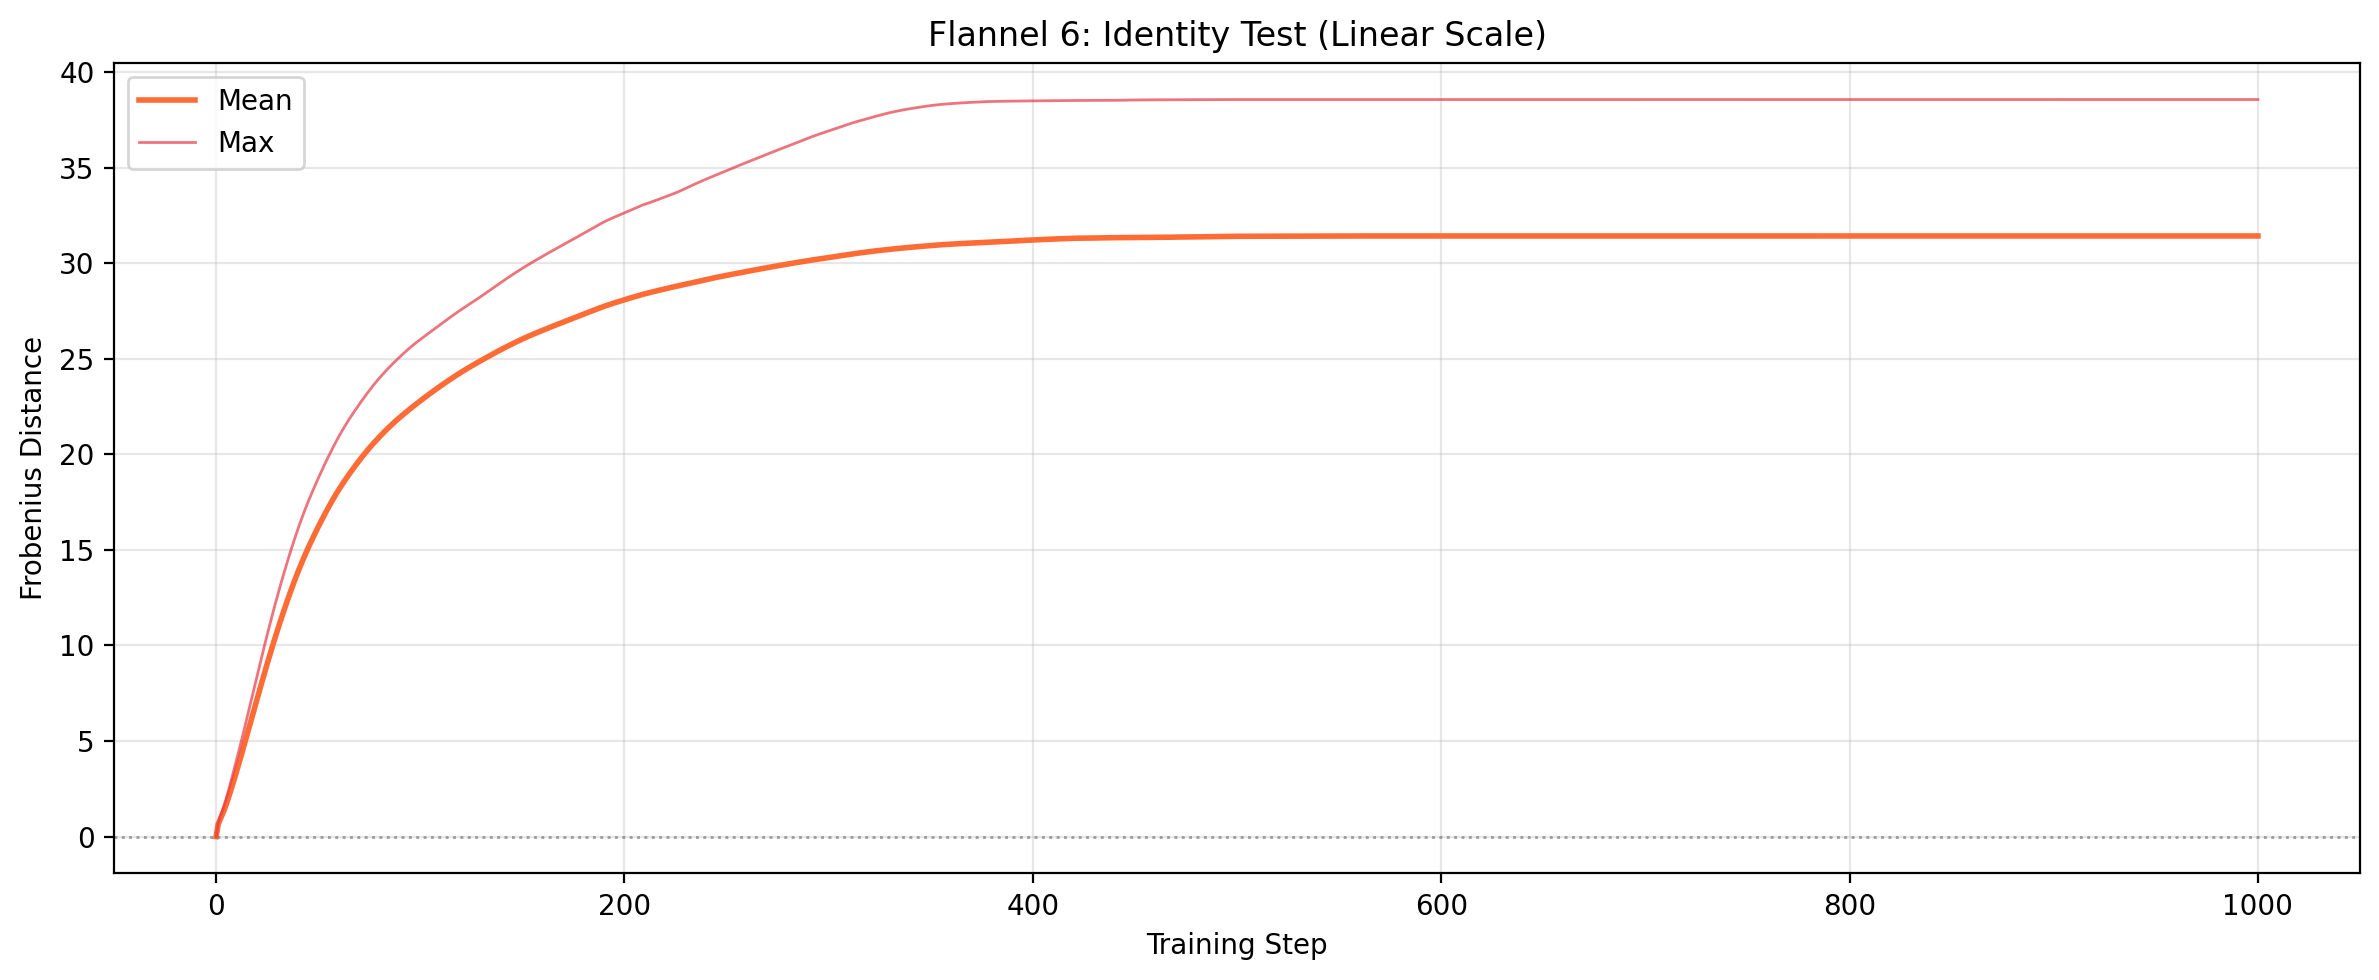

In [ ]:
# Linear scale version (if differences are truly tiny)
fig, ax = plt.subplots(figsize=(12, 5), dpi=DPI)

ax.plot(frob_mean.numpy(), linewidth=2, color='#FF6B35', label='Mean')
ax.plot(frob_max.numpy(), linewidth=1, color='#E63946', label='Max', alpha=0.7)

ax.set_xlabel('Training Step')
ax.set_ylabel('Frobenius Distance')
ax.set_title('Flannel 6: Identity Test (Linear Scale)')
ax.grid(True, alpha=0.3)
ax.legend()

# Add horizontal reference lines for numerical precision
ax.axhline(1e-6, color='gray', linestyle=':', linewidth=1, alpha=0.5, label='1e-6 (bfloat16 ~precision)')
ax.axhline(1e-10, color='gray', linestyle=':', linewidth=1, alpha=0.3, label='1e-10')
ax.axhline(1e-15, color='gray', linestyle=':', linewidth=1, alpha=0.2, label='1e-15 (float64 precision)')

plt.tight_layout()
plt.show()

## Growth Rate of Differences

If runs diverge, how fast does divergence grow?

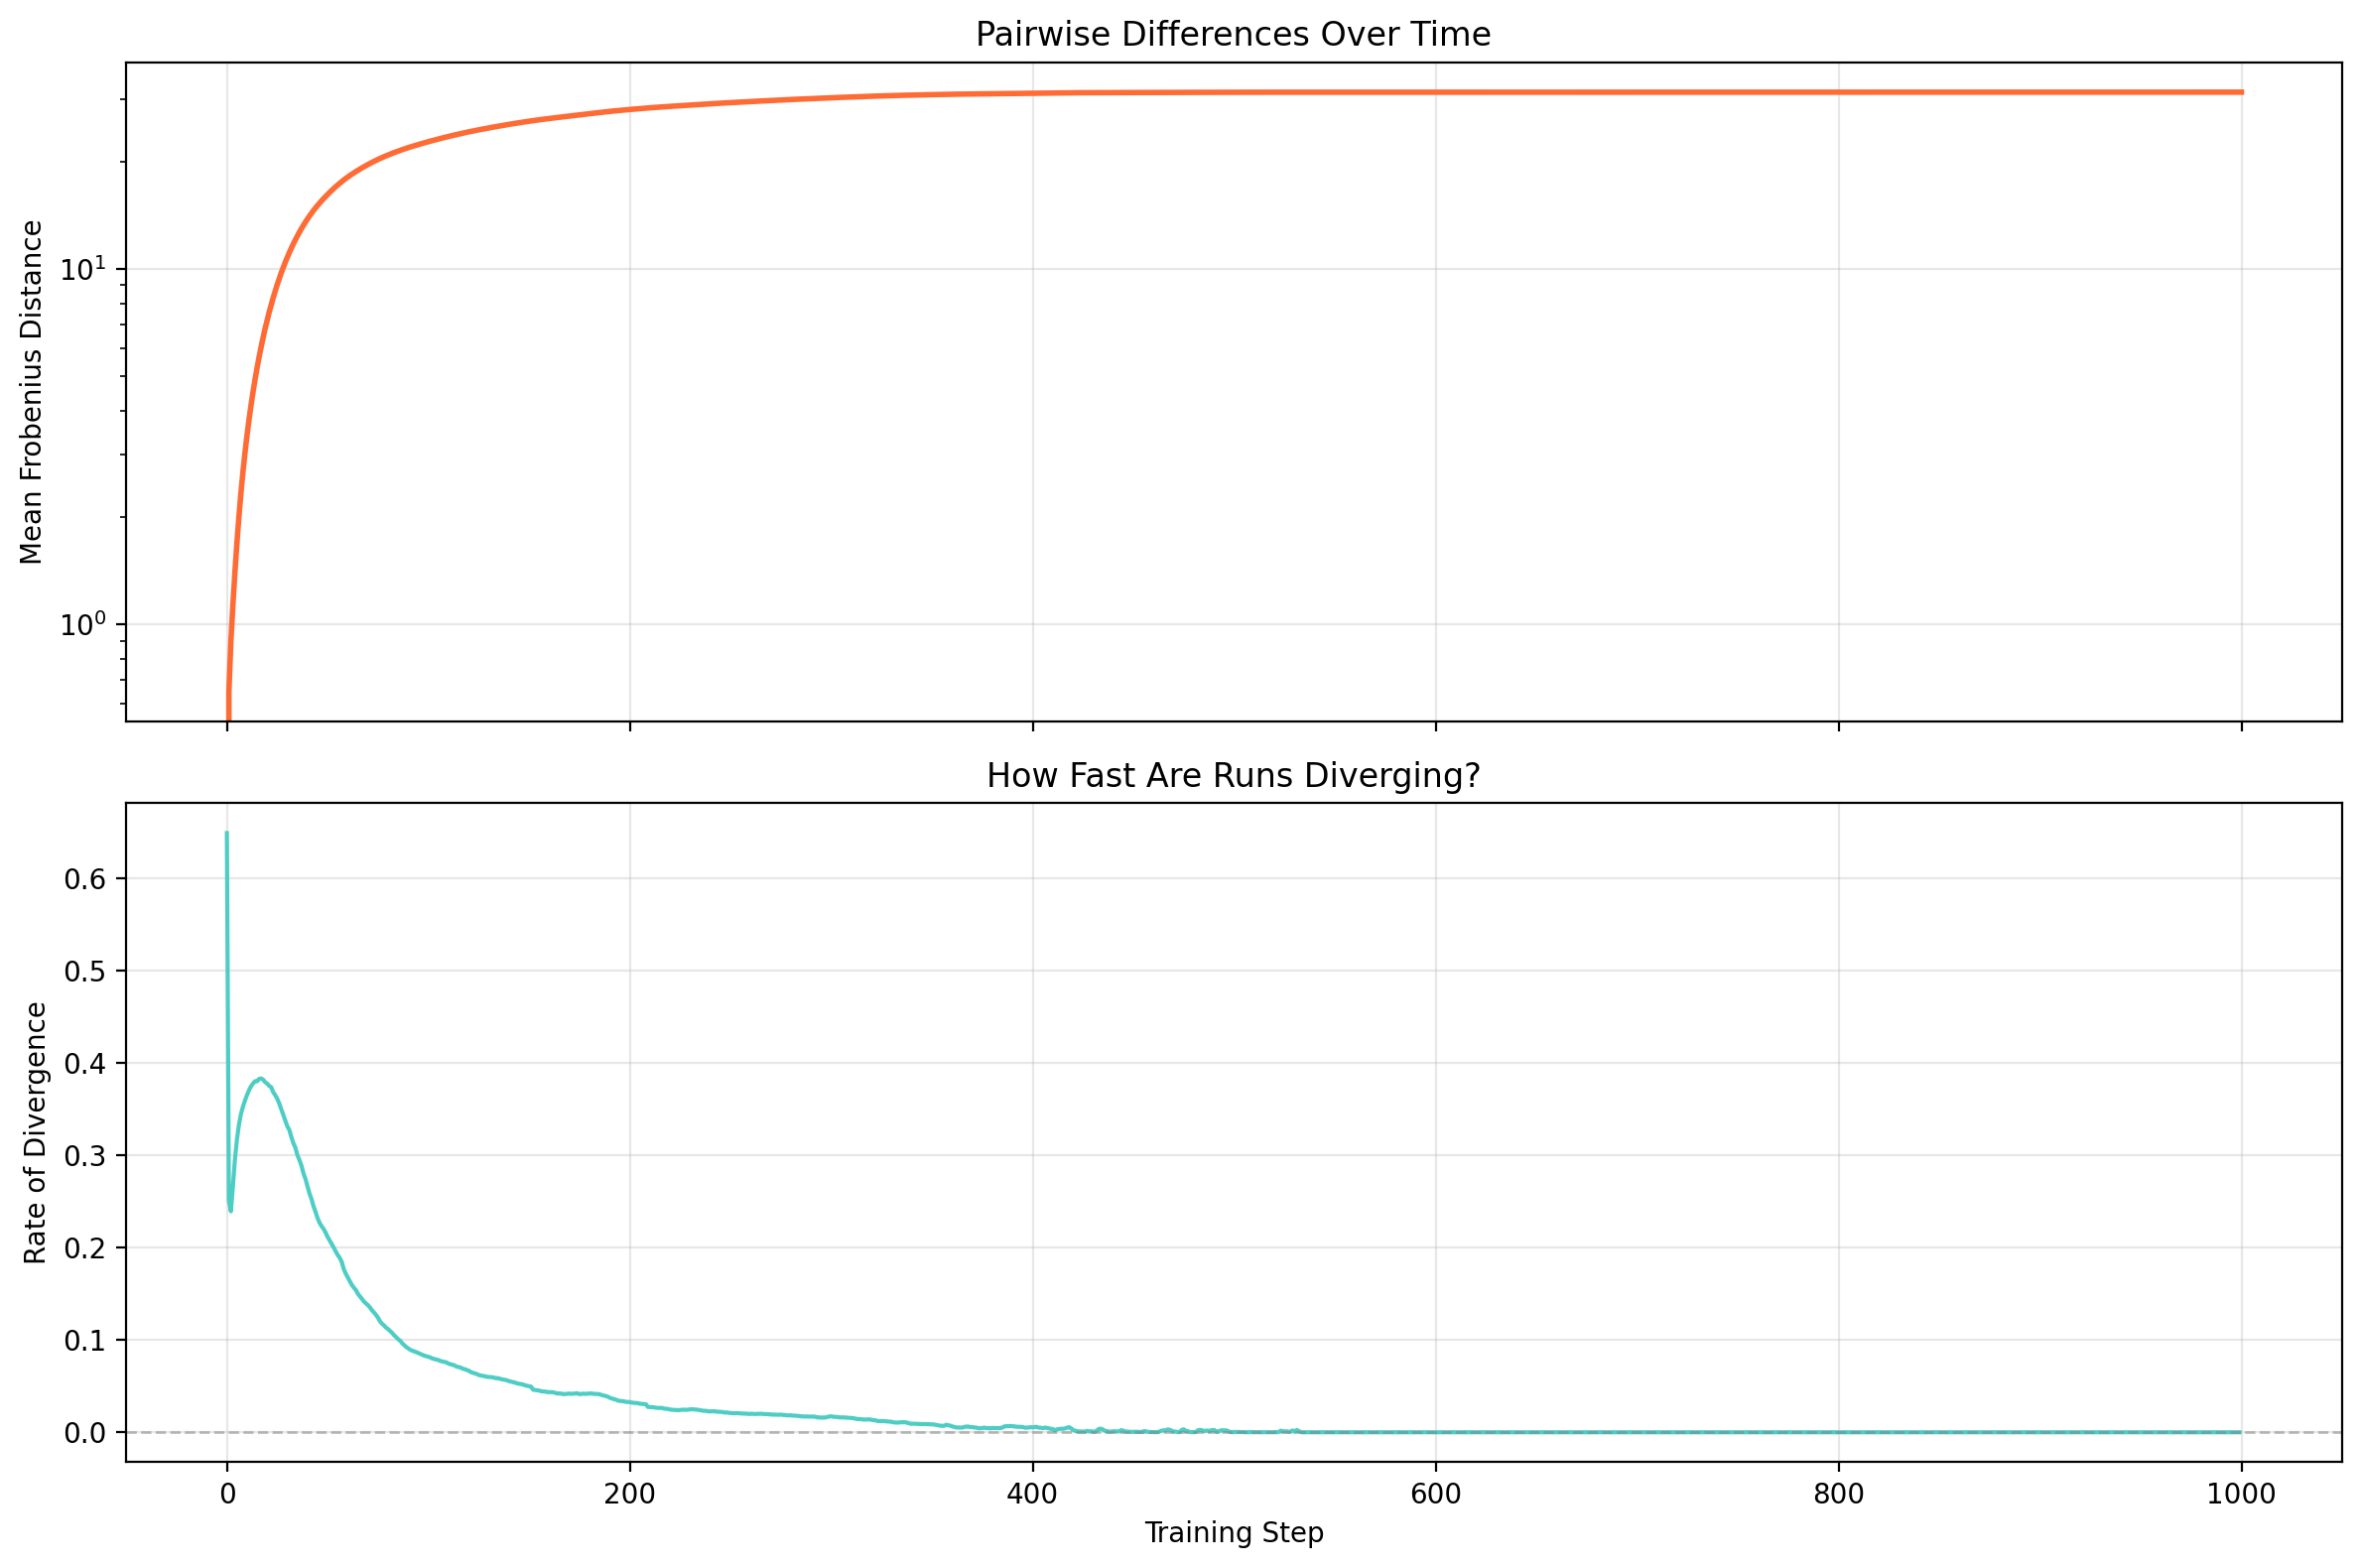

In [ ]:
# Rate of change
diff_velocity = torch.diff(frob_mean)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), dpi=DPI, sharex=True)

# Panel 1: Mean difference
ax1.plot(frob_mean.numpy(), linewidth=2, color='#FF6B35')
ax1.set_ylabel('Mean Frobenius Distance')
ax1.set_title('Pairwise Differences Over Time')
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# Panel 2: Rate of change
ax2.plot(diff_velocity.numpy(), linewidth=1.5, color='#4ECDC4')
ax2.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax2.set_xlabel('Training Step')
ax2.set_ylabel('Rate of Divergence')
ax2.set_title('How Fast Are Runs Diverging?')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Distribution of Differences at Key Timesteps

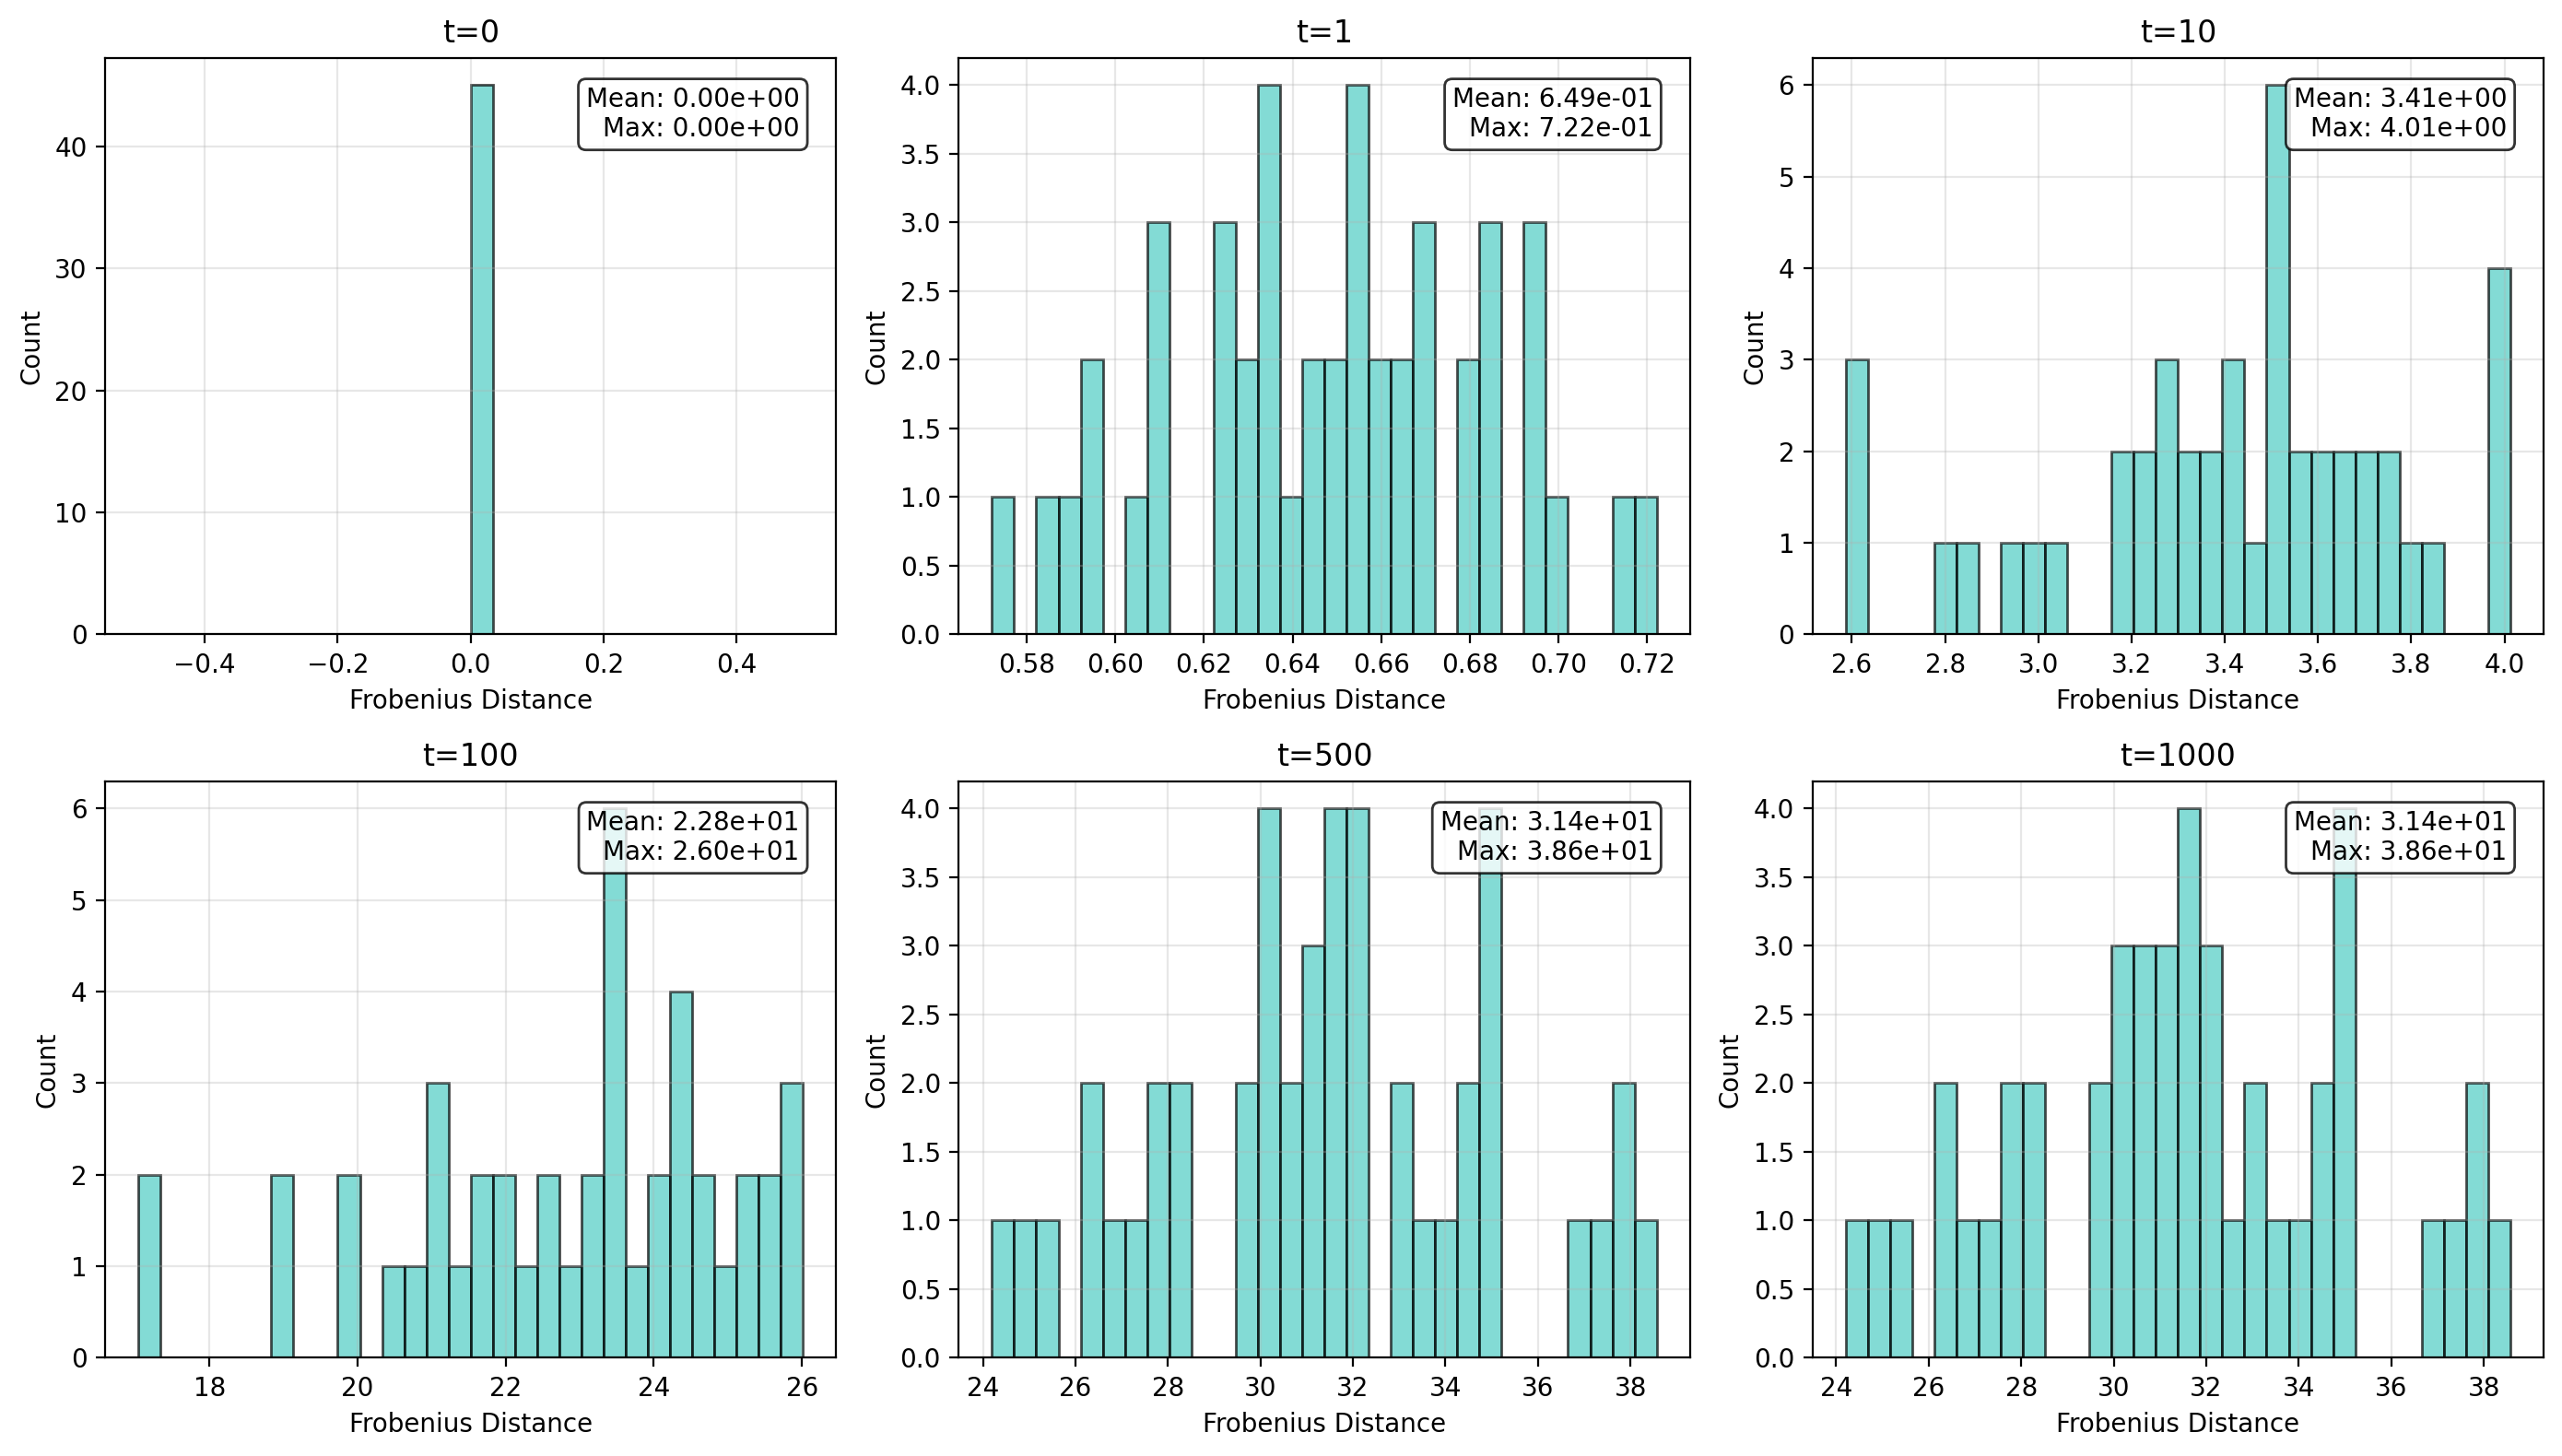

In [ ]:
# Look at distribution of pairwise differences at specific times
sample_times = [0, 1, 10, 100, 500, 1000]

fig, axes = plt.subplots(2, 3, figsize=(14, 8), dpi=DPI)
axes = axes.flatten()

for idx, t in enumerate(sample_times):
    ax = axes[idx]
    
    diffs = pairwise_frob[t].numpy()
    
    ax.hist(diffs, bins=30, color='#4ECDC4', alpha=0.7, edgecolor='black')
    ax.set_xlabel('Frobenius Distance')
    ax.set_ylabel('Count')
    ax.set_title(f't={t}')
    ax.grid(True, alpha=0.3)
    
    # Add stats
    ax.text(0.95, 0.95, f'Mean: {diffs.mean():.2e}\nMax: {diffs.max():.2e}',
            transform=ax.transAxes, ha='right', va='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

## Summary

In [ ]:
print("="*70)
print("FLANNEL 6 IDENTITY CHECK SUMMARY")
print("="*70)
print()

print(f"EXPERIMENTAL SETUP:")
print(f"  Runs:                    {n_runs}")
print(f"  Initialization seed:     {init_seed} (SHARED)")
print(f"  Training seeds:          {base_train_seed}–{base_train_seed + n_runs - 1}")
print(f"  Pairwise comparisons:    {n_pairs}")
print()

print(f"INITIAL STATE (t=0):")
print(f"  Max difference:          {frob_max[0]:.15e}")
print(f"  Exactly identical:       {exactly_zero[0].item()}/{n_pairs} pairs")
print()

print(f"FINAL STATE (t={n_steps-1}):")
print(f"  Mean difference:         {frob_mean[-1]:.15e}")
print(f"  Median difference:       {frob_median[-1]:.15e}")
print(f"  Max difference:          {frob_max[-1]:.15e}")
print(f"  Exactly identical:       {exactly_zero[-1].item()}/{n_pairs} pairs")
print()

print(f"INTERPRETATION:")

if frob_max[-1] == 0.0:
    print(f"  ✓ PERFECTLY DETERMINISTIC (bit-for-bit identical)")
    print(f"  → Training produces exactly the same result every time")
    print(f"  → Training seed has NO effect on trajectory")
    print(f"  → Only initialization matters for Flannel dynamics")
    
elif frob_max[-1] < 1e-10:
    print(f"  ✓ EFFECTIVELY DETERMINISTIC (within floating-point precision)")
    print(f"  → Differences are at the limit of numerical representation")
    print(f"  → Likely due to rounding errors, not true randomness")
    print(f"  → Training seed has negligible effect")
    
elif frob_max[-1] < 1e-3:
    print(f"  ⚠ MOSTLY DETERMINISTIC but with small drift")
    print(f"  → Differences are small but non-negligible")
    print(f"  → Training seed affects trajectory slightly")
    print(f"  → Batch ordering or other factors have minor influence")
    
else:
    print(f"  ✗ STOCHASTIC (significant divergence)")
    print(f"  → Different training seeds produce different outcomes")
    print(f"  → Batch ordering or other randomness affects evolution")
    print(f"  → Cannot treat training as deterministic")

print()

# Compare to typical evolution magnitude
typical_evolution = torch.norm(W_dead[0, -1] - W_dead[0, 0], p='fro').item()
divergence_ratio = frob_mean[-1].item() / typical_evolution if typical_evolution > 0 else 0

print(f"CONTEXT:")
print(f"  Typical evolution magnitude: {typical_evolution:.6f}")
print(f"  Divergence / Evolution:      {divergence_ratio:.10f}")
print(f"  → Inter-run differences are {divergence_ratio*100:.8f}% of total evolution")
print()
print("="*70)

FLANNEL 6 IDENTITY CHECK SUMMARY

EXPERIMENTAL SETUP:
  Runs:                    10
  Initialization seed:     42 (SHARED)
  Training seeds:          42–51
  Pairwise comparisons:    45

INITIAL STATE (t=0):
  Max difference:          0.000000000000000e+00
  Exactly identical:       45/45 pairs

FINAL STATE (t=1000):
  Mean difference:         3.143043708801270e+01
  Median difference:       3.140563201904297e+01
  Max difference:          3.857075500488281e+01
  Exactly identical:       0/45 pairs

INTERPRETATION:
  ✗ STOCHASTIC (significant divergence)
  → Different training seeds produce different outcomes
  → Batch ordering or other randomness affects evolution
  → Cannot treat training as deterministic

CONTEXT:
  Typical evolution magnitude: 31.575218
  Divergence / Evolution:      0.9954147233
  → Inter-run differences are 99.54147233% of total evolution

